# Coding assessment: Train a text classification model to detect fake news articles!


In [1]:
#Import all libraries
import nltk
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from wordcloud import WordCloud, STOPWORDS
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


# Part 1:- Datasets from Kaggle

In [2]:
true_df = pd.read_csv("data/True.csv")
fake_df = pd.read_csv("data/Fake.csv")
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
fake_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [4]:
true_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [5]:
#concatenate true and fake df
# True == 1 , fake == 0
true_df["label"] = 1
fake_df["label"] = 0
frames = [true_df, fake_df]
combined_df = pd.concat(frames)
combined_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
print("True news subjects: ",true_df["subject"].unique())
print("Fake news subjects: ",fake_df["subject"].unique())

True news subjects:  ['politicsNews' 'worldnews']
Fake news subjects:  ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


In [7]:
combined_df = combined_df.loc[:,["text","label"]]
combined_df.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


# Preprocessing of data

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
test_article = combined_df.iloc[0,0]
test_article

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

In [10]:
contraction_map = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
}
def expand_abbr(article):
    new_article = article
    for item in contraction_map:
        if item in article:
            new_article = article.replace(item,contraction_map[item])
    return new_article

def uncapitalize(article):
    return article.lower()

def remove_stopwords(article):
    word_tokens = word_tokenize(article)
    filtered_article = []
    for tok in word_tokens:
        if tok not in STOP_WORDS:
            filtered_article.append(lemmatizer.lemmatize(tok))
#     filtered_article = [w for w in word_tokens if not w in stop_words]
    return filtered_article

all_punctuation = set(string.punctuation)
all_punctuation.add("...")
all_punctuation.add('’')
all_punctuation.add('-')
all_punctuation.add('“')
all_punctuation.add('[')
all_punctuation.add(']')

def remove_punctuation(token_list):
    new_list = []
    for tok in token_list:
        if tok not in all_punctuation:
            new_list.append(tok)
    return new_list



# Remove,punctuations, lower-casing, removing stopwords.

In [11]:
combined_df["text"] = combined_df["text"].apply(expand_abbr)
combined_df["text"] = combined_df["text"].apply(uncapitalize)
combined_df["text"] = combined_df["text"].apply(remove_stopwords)
combined_df["text"] = combined_df["text"].apply(remove_punctuation)


In [12]:
combined_df["text"] = combined_df["text"].apply(lambda x:" ".join(x))
combined_df.head()

,text,label
0,washington reuters head conservative republica...,1
1,washington reuters transgender people allowed ...,1
2,washington reuters special counsel investigati...,1
3,washington reuters trump campaign adviser geor...,1
4,seattle/washington reuters president donald tr...,1


In [13]:
X = combined_df["text"]
y = combined_df["label"]

# Training and test sets 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
vectorizer = TfidfVectorizer(max_features=1000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

# Part 2 ,3:- Develop and Train Models and evaluation (F1-score, Accuracy, AUC) 

**********Logistic Regression**********
accuracy:    99.124
Precision:   98.862
Recall:      99.320
F1 Score:    99.091
ROC AUC: 0.9989217325827919


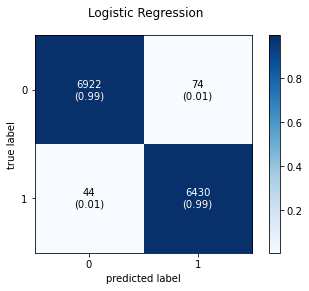

**********Random Forest Classifier**********
accuracy:    99.762
Precision:   99.753
Recall:      99.753
F1 Score:    99.753
ROC AUC: 0.9999740683276714


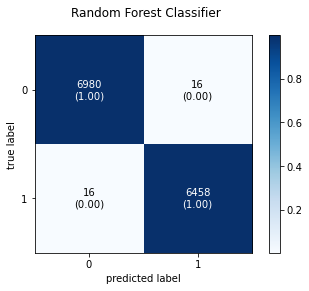

**********Linear SVC**********
accuracy:    99.592
Precision:   99.415
Recall:      99.737
F1 Score:    99.576
ROC AUC: 0.9993754319737498


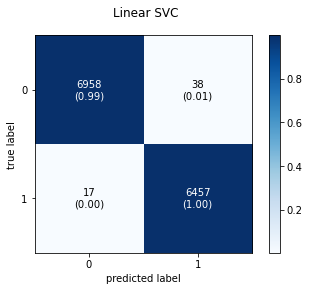

**********Decision Tree Classifier**********
accuracy:    99.599
Precision:   99.690
Recall:      99.475
F1 Score:    99.582
ROC AUC: 0.9958598964623061


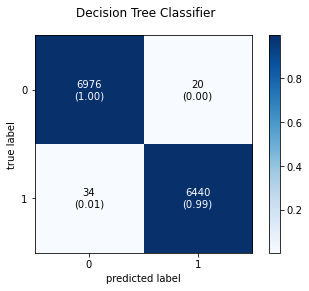

In [16]:
AUC_dict = {}
tpr={}
fpr={}

model_dict={"Logistic Regression":LogisticRegression(),"Random Forest Classifier":RandomForestClassifier(),"Linear SVC":LinearSVC(),"Decision Tree Classifier":DecisionTreeClassifier()}
for key in model_dict.keys():
    print(f"**********{key}**********")
    model= model_dict[key]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    f1score = f1_score(y_test,y_pred)
    recallscore=recall_score(y_test,y_pred)
    pre_score=precision_score(y_test,y_pred)
    print("accuracy:    %0.3f" % (accuracy*100))
    print("Precision:   %0.3f" % (pre_score*100))
    print("Recall:      %0.3f" % (recallscore*100))
    print("F1 Score:    %0.3f" % (f1score*100))
    if key =="Linear SVC":
        svc_clf = CalibratedClassifierCV(model)
        svc_clf.fit(X_train, y_train)
        model_probs = svc_clf.predict_proba(X_test)[:,1]
    else:
        model_probs = model.predict_proba(X_test)[:,1]
    model_auc = roc_auc_score(y_test,model_probs)
    print(f"ROC AUC: {model_auc}")
    AUC_dict[key] = model_auc
    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, y_pred),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
    plt.suptitle(key)
    plt.show()
    ns_probs = [0 for _ in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    tpr["No Skill"]=ns_tpr
    fpr["No Skill"]=ns_fpr
    model_fpr, model_tpr, _ = roc_curve(y_test, model_probs)
    tpr[key]=model_tpr
    fpr[key]=model_fpr




# ROC Curve

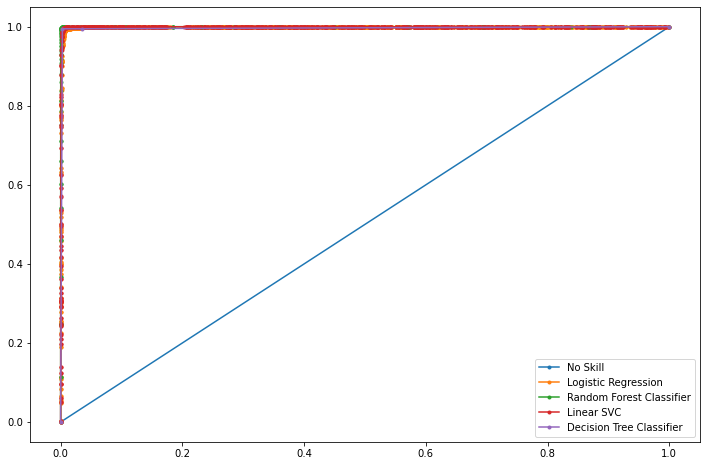

In [23]:
plt.figure(figsize=(12,8))
for i, j in zip(tpr.keys(), fpr.keys()):
    #no skills
    if i=="No Skills" and j== "No Skills":
        plt.plot(fpr[i],tpr[j], marker='.', label=i)
    #other models
    if i==j and i!="No Skills":
         plt.plot(fpr[i],tpr[j], marker='.', label=i)
plt.legend()



# Part 4:- Word Clouds for true and fake news showing top ten words.

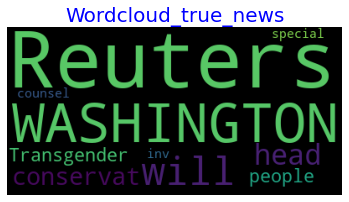

In [18]:
wordcloud2 = WordCloud(
                          background_color='black',
                          stopwords=STOPWORDS,
                          max_words=10,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(true_df['text']))

plt.imshow(wordcloud2)
title=plt.title("Wordcloud_true_news",fontsize=20)
plt.setp(title, color='b')
plt.axis('off')
plt.show()

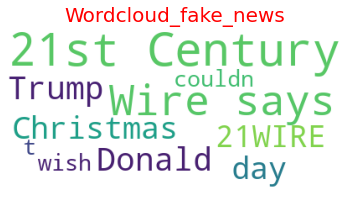

In [19]:
wordcloud2 = WordCloud(
                          background_color='white',
                          stopwords=STOPWORDS,
                          max_words=10,
                          max_font_size=100, 
                          random_state=42
                         ).generate(str(fake_df['text']))

plt.imshow(wordcloud2)
title=plt.title("Wordcloud_fake_news",fontsize=20)
plt.setp(title, color='r')
plt.axis('off')
plt.show()

# Conclusion

(0.99, 0.99999)

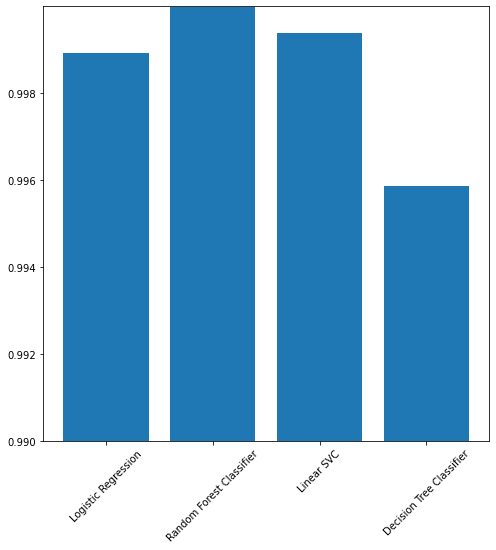

In [26]:
plt.figure(figsize=(8,8))
plt.xticks(rotation=45)
plt.bar(AUC_dict.keys(), AUC_dict.values())
plt.ylim(0.99,0.99999)